In [3]:
import os
import gc
import cv2
import time
import lime
import psutil
import lime
import random
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import lime.lime_image
import seaborn as sns
import tensorflow as tf
import kerastuner as kt
import matplotlib.pyplot as plt
from sklearn.utils import resample
from tensorflow.keras import layers, Model
import lime.lime_image
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from skimage.segmentation import mark_boundaries
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
warnings.filterwarnings("ignore", category=UserWarning)
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize

Number of training samples: 12362
Number of test samples: 3091


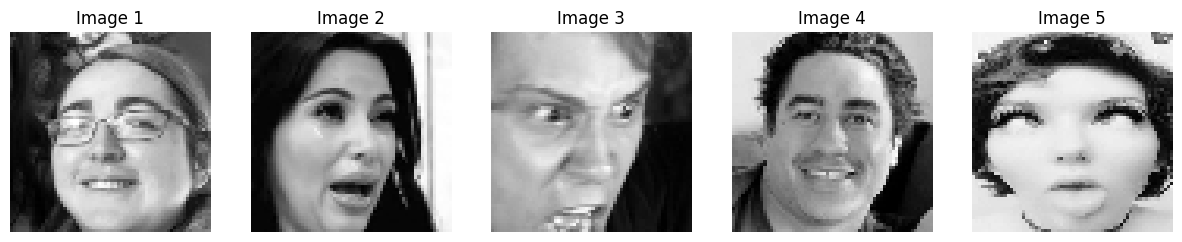

In [4]:
data_dir = '/kaggle/input/faceex/dataset'
categories = ['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
IMG_SIZE = 64  # Increasing the image size to reduce blurriness.
batch_size = 32

# Function to preprocess images
def preprocess_image(file_path, label, augment=False): # Reading and decode image
    
    img_raw = tf.io.read_file(file_path)
    img_decoded = tf.image.decode_image(img_raw, channels=3, expand_animations=False)
    
    # Resizing image
    img_resized = tf.image.resize(img_decoded, [IMG_SIZE, IMG_SIZE])
    
    if augment:   # Data augmentation
        
        img_resized = tf.image.random_flip_left_right(img_resized)
        img_resized = tf.image.random_brightness(img_resized, max_delta=0.2)
        img_resized = tf.image.random_contrast(img_resized, lower=0.8, upper=1.2)
    
    # Converting to grayscale
    img_gray = tf.image.rgb_to_grayscale(img_resized)
    
    # Normalizing image
    img_normalized = tf.cast(img_gray, tf.float32) / 255.0
    
    return img_normalized, label

# Loading image paths and their corresponding label
def load_images_and_labels(data_dir, categories):
    paths = []
    labels = []
    for label, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        category_files = tf.io.gfile.listdir(category_dir)
        paths.extend([os.path.join(category_dir, file) for file in category_files])
        labels.extend([label] * len(category_files))
    return paths, labels

paths, labels = load_images_and_labels(data_dir, categories)

# Encoding labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Splitting data
train_paths, test_paths, train_labels, test_labels = train_test_split(paths, encoded_labels, test_size=0.2, stratify=encoded_labels)

# Printing the number of training and test sample.
print(f'Number of training samples: {len(train_paths)}')
print(f'Number of test samples: {len(test_paths)}')

# Creating TensorFlow dataset
train_data = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

# Applying preprocessing and batching
train_data = train_data.map(lambda x, y: preprocess_image(x, y, augment=True)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(lambda x, y: preprocess_image(x, y, augment=False)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Function to visualize preprocessed images
def visualize_preprocessed_images(dataset, num_images=5):
    
    for images, _ in dataset.take(1):
        images = images.numpy()
        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].squeeze(), cmap='gray')
            plt.title(f"Image {i+1}")
            plt.axis("off")
        plt.show()

# Visualizing preprocessed training images
visualize_preprocessed_images(train_data, num_images=5)


Trial 10 Complete [00h 05m 27s]
val_loss: 0.0

Best val_loss So Far: 0.0
Total elapsed time: 00h 33m 14s
Best latent_dim: 8
Best num_neurons: 128
Best learning_rate: 0.0010748080614242867
Best kl_weight: 0.5
Training with best hyperparameters:
Epoch 1/2
387/387 ━━━━━━━━━━━━━━━━━━━━ 61s 157ms/step - kl_loss: 0.0045 - loss: 0.6146 - reconstruction_loss: 0.6123 - val_loss: 0.0000e+00
Epoch 2/2
387/387 ━━━━━━━━━━━━━━━━━━━━ 61s 157ms/step - kl_loss: 0.0053 - loss: 0.5936 - reconstruction_loss: 0.5909 - val_loss: 0.0000e+00
Tuned reconstruction loss: 0.5928
Models saved successfully.
Complete VAE model saved successfully.


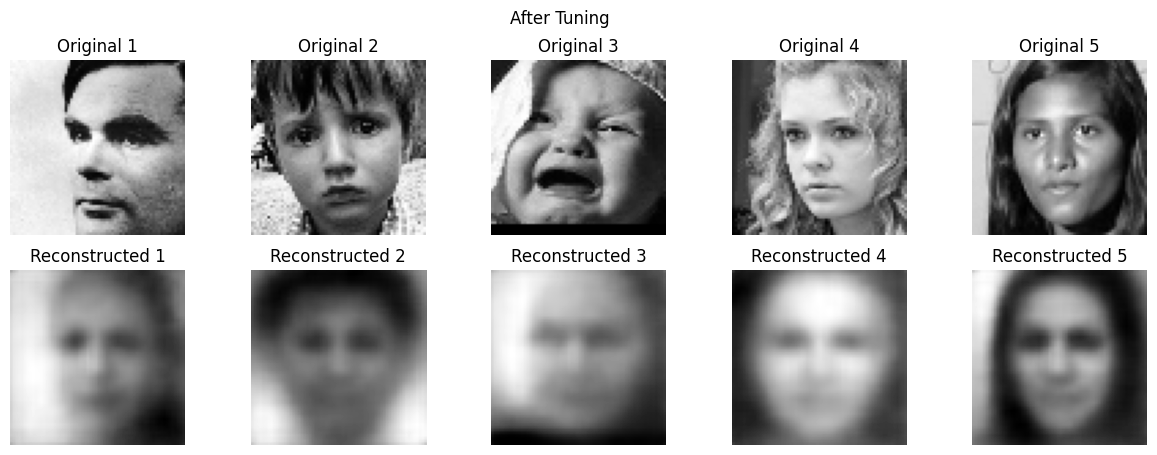

In [10]:
# To suppress the warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'   
warnings.filterwarnings('ignore')   

# Mixed precision policy
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

class VAE(Model):
    def __init__(self, encoder, decoder, kl_weight=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = kl_weight

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)  # input to float32
        z_mean, z_log_var = self.encoder(inputs)
        z_mean = tf.cast(z_mean, tf.float32)
        z_log_var = tf.cast(z_log_var, tf.float32)
        z = z_mean + tf.exp(0.5 * z_log_var) * tf.random.normal(shape=tf.shape(z_mean), dtype=tf.float32)
        reconstructed = self.decoder(tf.cast(z, tf.float16))
        return reconstructed, z_mean, z_log_var

    def train_step(self, data):
        images, _ = data
        images = tf.cast(images, tf.float32)  # image to float32
        with tf.GradientTape() as tape:
            reconstruction, z_mean, z_log_var = self(images)
            flat_data = tf.reshape(images, [tf.shape(images)[0], -1])
            flat_reconstruction = tf.reshape(reconstruction, [tf.shape(reconstruction)[0], -1])
            reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(flat_data, flat_reconstruction))
            IMG_SIZE = tf.cast(images.shape[1], tf.float32) 
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)) / (IMG_SIZE * IMG_SIZE)
            total_loss = tf.cast(reconstruction_loss, tf.float32) + tf.cast(self.kl_weight * kl_loss, tf.float32)  # Ensuring total_loss is float32
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {'loss': total_loss, 'reconstruction_loss': reconstruction_loss, 'kl_loss': kl_loss}

def build_encoder(latent_dim=16, num_neurons=128): # Building encoder
    encoder_input = layers.Input(shape=(64, 64, 1))  # Adjusted to match the IMG_SIZE. 
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(num_neurons, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    encoder = Model(encoder_input, [z_mean, z_log_var])
    return encoder

def build_decoder(latent_dim=16, num_neurons=128): # Building decoder
    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(16*16*64, activation='relu')(decoder_input)
    x = layers.Reshape((16, 16, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    decoder = Model(decoder_input, x)
    return decoder

# Function to visualize images
def visualize_reconstructed_images(model, dataset, num_images=5, title=""):
    for images, _ in dataset.take(1):
        reconstructed, _, _ = model(images)
        reconstructed = tf.cast(reconstructed, tf.float32)  # float32 for visualization
        images = tf.cast(images, tf.float32)
        
        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            # Display original images
            ax = plt.subplot(2, num_images, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title(f"Original {i+1}")
            plt.axis("off")
            
            # Display reconstructed images
            ax = plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(reconstructed[i].numpy().squeeze(), cmap='gray')
            plt.title(f"Reconstructed {i+1}")
            plt.axis("off")
        plt.suptitle(title)
        plt.show()

# Function to evaluate & print accuracy
def evaluate_accuracy(model, dataset):
    reconstruction_losses = []
    for images, _ in dataset:
        reconstructed, _, _ = model(images)
        flat_data = tf.reshape(images, [tf.shape(images)[0], -1])
        flat_reconstruction = tf.reshape(reconstructed, [tf.shape(reconstructed)[0], -1])
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(flat_data, flat_reconstruction))
        reconstruction_losses.append(reconstruction_loss)
    avg_reconstruction_loss = tf.reduce_mean(reconstruction_losses)
    return avg_reconstruction_loss

# Initial training started 
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-7), loss=lambda y_true, y_pred: 0)

print("Initial training:")
history = vae.fit(train_data, epochs=10, validation_data=test_data)
initial_reconstruction_loss = evaluate_accuracy(vae, test_data)
print(f"Initial reconstruction loss: {initial_reconstruction_loss:.4f}")

visualize_reconstructed_images(vae, test_data, num_images=5, title="Before Tuning")

# Hyperparameter tuning started
def build_vae_model(hp):
    latent_dim = hp.Int('latent_dim', min_value=8, max_value=64, step=8)
    num_neurons = hp.Int('num_neurons', min_value=64, max_value=512, step=64)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    kl_weight = hp.Float('kl_weight', min_value=0.1, max_value=2.0, step=0.1)
    
    encoder = build_encoder(latent_dim=latent_dim, num_neurons=num_neurons)
    decoder = build_decoder(latent_dim=latent_dim, num_neurons=num_neurons)
    
    vae = VAE(encoder, decoder, kl_weight=kl_weight)
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=lambda y_true, y_pred: 0)
    
    return vae

tuner = kt.Hyperband(
    build_vae_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='hyperband_dir',
    project_name='vae_tuning'
)

tuner.search_space_summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_data, epochs=10, validation_data=test_data, callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best latent_dim: {best_hps.get('latent_dim')}")
print(f"Best num_neurons: {best_hps.get('num_neurons')}")
print(f"Best learning_rate: {best_hps.get('learning_rate')}")
print(f"Best kl_weight: {best_hps.get('kl_weight')}")

best_model = tuner.hypermodel.build(best_hps)

print("Training with best hyperparameters:")
history = best_model.fit(train_data, epochs=2, validation_data=test_data, callbacks=[stop_early])
tuned_reconstruction_loss = evaluate_accuracy(best_model, test_data)
print(f"Tuned reconstruction loss: {tuned_reconstruction_loss:.4f}")

encoder = best_model.encoder
decoder = best_model.decoder

encoder.save('vae_encoder.h5')
decoder.save('vae_decoder.h5')
print("Models saved successfully.")

best_model.save('vae_complete_model.h5')
print("Complete VAE model saved successfully.")

visualize_reconstructed_images(best_model, test_data, num_images=5, title="After Tuning")